In this notebook, we'll be looking at the data and we'll do some basic exploratary data analysis

In [8]:
import os
import re
import glob
import h5py
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
sys.path.append('../')
warnings.filterwarnings('ignore')

In [9]:
path_to_input = "../data"

In [10]:
# list of cities
all_cities = [city for city in os.listdir(path_to_input)]
print(all_cities)

['ANTWERP', 'BANGKOK', 'BARCELONA', 'BERLIN', 'CHICAGO', 'ISTANBUL', 'MELBOURNE', 'MOSCOW', 'NEWYORK', 'VIENNA']


In [11]:
core_challenge_cities = [re.search(r"([A-Z]+)", file).group(1) for file in glob.glob(path_to_input+"/**/*test_temporal.h5", recursive=True)]

extended_challenge_cities = [re.search(r"([A-Z]+)", file).group(1) for file in glob.glob(path_to_input+"/**/*test_spatiotemporal.h5", recursive=True)]

print("Cities for core challenge: ",core_challenge_cities)

print("Cities for extended challenge: ",extended_challenge_cities)


Cities for core challenge:  ['BERLIN', 'CHICAGO', 'ISTANBUL', 'MELBOURNE']
Cities for extended challenge:  ['NEWYORK', 'VIENNA']


In [12]:
# cities for training 
training_cities = [city for city in all_cities if city not in core_challenge_cities and city not in extended_challenge_cities]
print("Cities for training: ", training_cities)

Cities for training:  ['ANTWERP', 'BANGKOK', 'BARCELONA', 'MOSCOW']


In [13]:
city = 'BERLIN'
path_to_days = glob.glob(path_to_input + f'/{city}/training/*')
chosen_day = path_to_days[-1]
day = re.search(r"([0-9]+-[0-9]+-[0-9]+)", chosen_day).group(1)
print(day)

2019-06-30


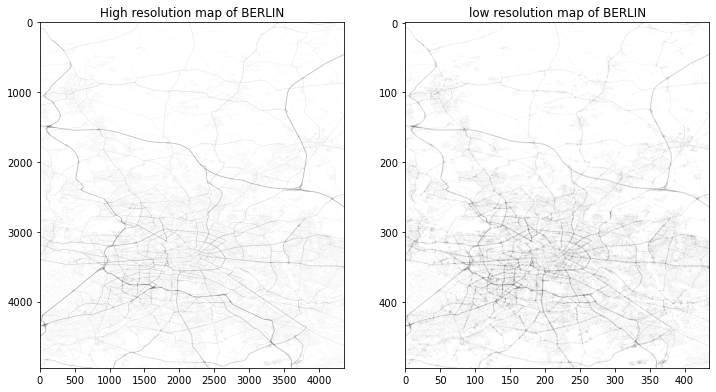

In [19]:
path_to_city = []
path_to_city.append(glob.glob(path_to_input + f"/{city}/*high_res.h5")[0])
path_to_city.append(glob.glob(path_to_input + f"/{city}/*static.h5")[0])
fig, ax = plt.subplots(1,2, figsize=(12,10))
axes = ax.ravel()
for index,file in enumerate(path_to_city):
    with h5py.File(file, "r") as f:
        image = f["array"]
        title = f"High resolution map of {city}"
        if image.ndim > 2:
            image = image[0,:,:]
            title = f"low resolution map of {city}"
        axes[index].imshow(image, cmap="gray_r", vmin=0, vmax=255)
        axes[index].set_title(title)

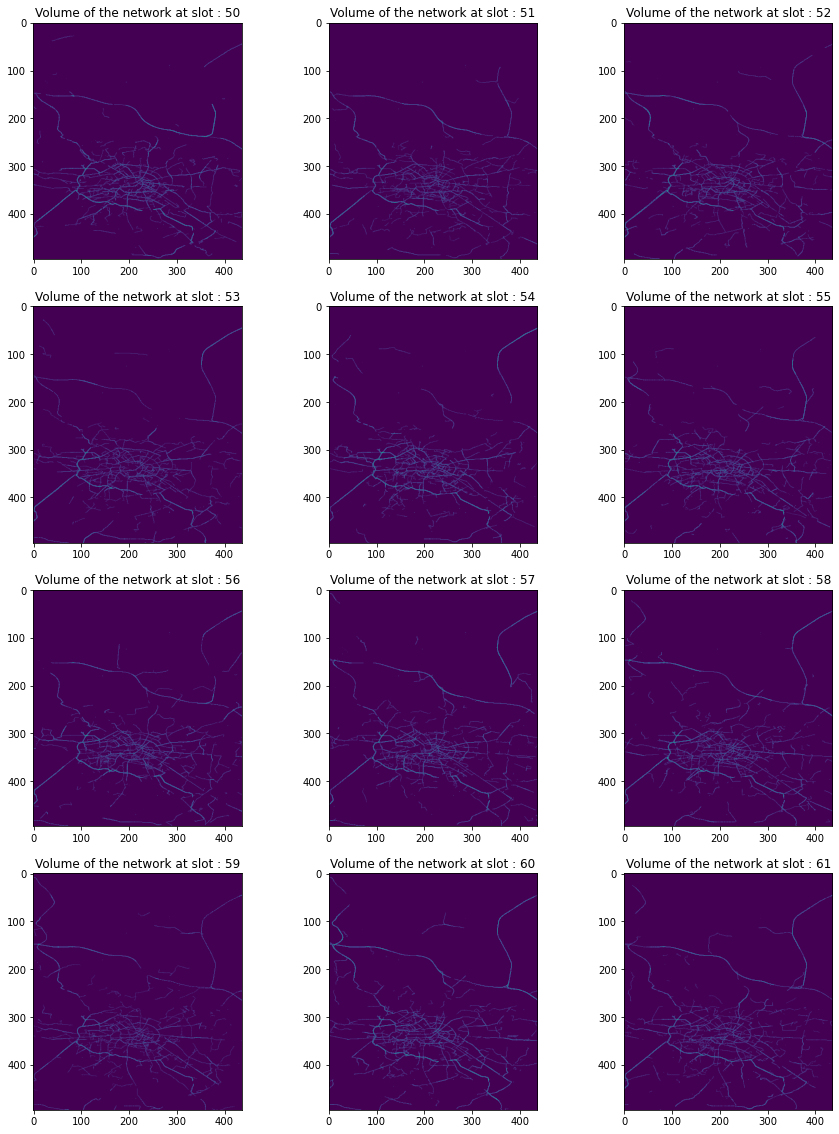

In [58]:
fig, ax = plt.subplots(4, 3, figsize =(15,20))
axes = ax.ravel()
j = 50 # start index
with h5py.File(chosen_day, "r") as f:
    image = np.array(f.get("array"))
    for i in range(len(axes)):
        img = image[i+j,:,:,:]
        sum_arr = np.zeros((img.shape[0],  img.shape[1]))
        for ch in range(8):
            channel = img[:,:,ch]
            sum_arr += channel
        axes[i].imshow(sum_arr)
        axes[i].set_title(f"Volume of the network at slot : {i+j}")

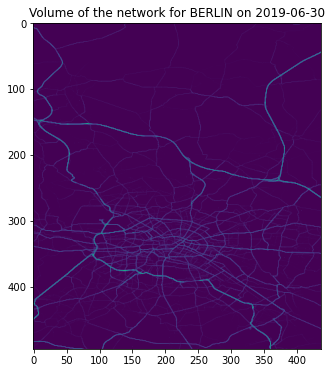

In [21]:
plt.figure(figsize=(8,6))
with h5py.File(chosen_day, "r") as f:
    image = f['array']
    temp = np.sum(image, axis=0)
    temp = np.sum(temp, axis=2)
    plt.imshow(temp)
    plt.title(f"Volume of the network for {city} on {day}")

In [49]:
test_data = glob.glob(path_to_input + f"/{city}/*test_temporal.h5")
with h5py.File(test_data[0], "r") as f:
    data = f.get("array")
    print(data.shape)

(100, 12, 495, 436, 8)


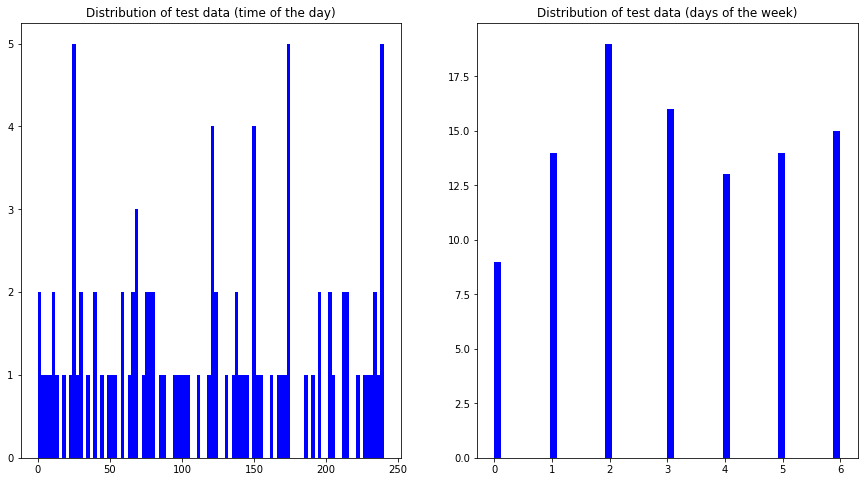

In [54]:
test_data_additional =  glob.glob(path_to_input + f"/{city}/*test_additional_temporal.h5")
fig, ax = plt.subplots(1,2, figsize=(15,8))
ax = ax.ravel()
with h5py.File(test_data_additional[0], "r") as f:
    data = f.get("array")
    time_of_the_day = data[:,1]
    counts, bins = np.histogram(time_of_the_day, 100)
    ax[0].hist(bins[:-1], bins, weights=counts, color="b")
    ax[0].set_title("Distribution of test data (time of the day)")
    day_of_the_week = data[:,0]
    counts, bins = np.histogram(day_of_the_week, 50)
    ax[1].hist(bins[:-1], bins, weights=counts, color="b")
    ax[1].set_title("Distribution of test data (days of the week)")
    plt.show()
    

<Figure size 576x432 with 0 Axes>

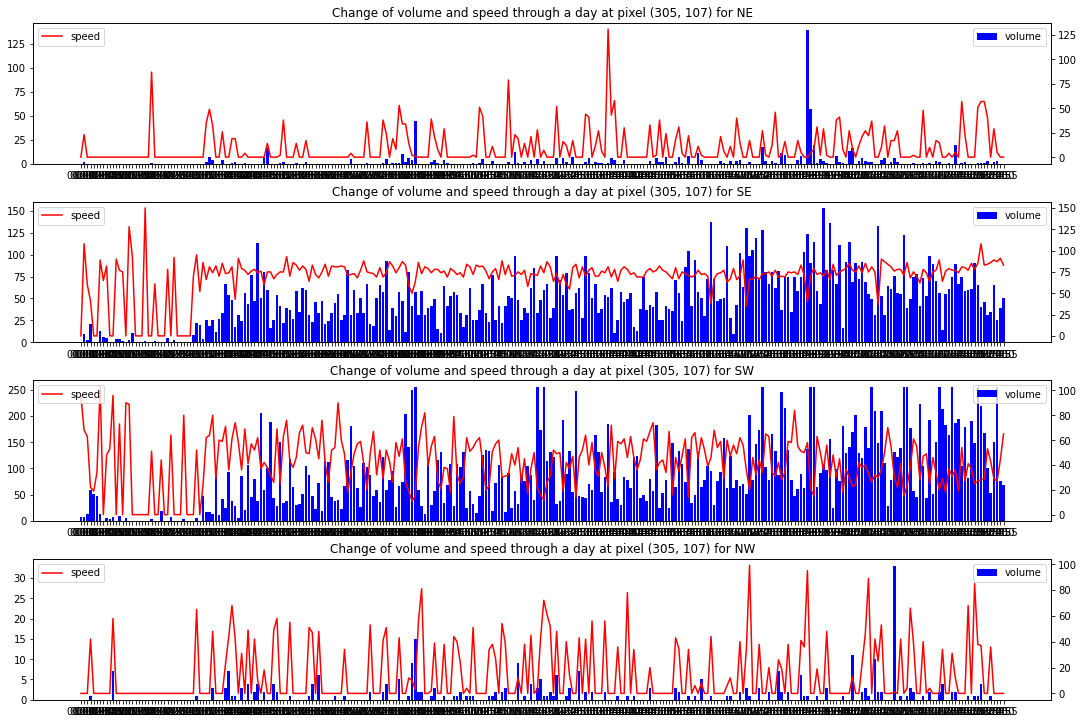

In [48]:
plt.figure(figsize=(8,6))

with h5py.File(chosen_day, "r") as f:
    
    sum_of_volumes = np.zeros((495,436))
    
    image = f['array']
    
    for v in [0,2,4,6]:
        img_vol = image[:,:,:,v]
        sum_vol = np.sum(img_vol, axis=0)
        sum_of_volumes += sum_vol
    
    max_value_index = np.unravel_index(np.argmax(sum_of_volumes), sum_of_volumes.shape)
        
    dates = [datetime.time(hour=t // 12, minute=t % 12 * 5).isoformat(timespec="minutes") for t in range(288)]
    
    fig, axes = plt.subplots(4,1, figsize = (15,10))
    axes = axes.ravel()
    plot_num = 0
    
    for v,direc in zip([0,2,4,6], ["NE", "SE", "SW", "NW"]):
        temp_img_vol = image[:, max_value_index[0], max_value_index[1], v]
        temp_img_speed = image[:,max_value_index[0], max_value_index[1], v+1]
        
        assert len(temp_img_vol) == len (dates)
        assert len(temp_img_speed) == len (dates)
        
        axes[plot_num].bar(dates, temp_img_vol, color="b", label = "volume")
        axes[plot_num].legend(loc="upper right")
        axes_2 = axes[plot_num].twinx()
        axes_2.plot(dates, temp_img_speed, color="r", label ="speed")               
        axes_2.legend(loc="upper left")
        axes[plot_num].set_title(f"Change of volume and speed through a day at pixel {max_value_index[0],max_value_index[1]} for {direc}")
        plot_num += 1
    plt.tight_layout(pad=0.5)
    plt.show()